# Polynomial Regression
This notebook is used to experiment with overfitting, underfitting, data distribution, noise, and cross-validation in polynomial regression.

In [2]:
import numpy as np
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
from numpy.random import rand, randn

In [3]:
def generate_data(p, beta, sig, n):
    """
     Generates data for polynomial regression.

     Args:
       p (int): Degree of the polynomial for data generation.
       beta (np.array): A column vector of the true polynomial coefficients [b_0, b_1, ..., b_p].T.
       sig (float): The standard deviation of the Gaussian noise (spread of the data).
       n (int): The number of data points to generate.

    Returns:
      tuple: A tuple containing:
        - u (np.array): A column vector of the independent variable values.
        - y (np.array): A column vector of the dependent variable values.

    """
    # Generate n feature values uniformly from [0, 1]
    u = np.random.rand(n, 1)

    # Generate the dependent variable values using the polynomial model with added Gaussian noise
    y = (u ** np.arange(0, p + 1)) @ beta + sig * np.random.randn(n, 1)
    return u, y

   

In [4]:
def model_matrix(p, u):
    """
    Constructs the design matrix (model matrix) for polynomial regression.

    Args:
       p (int): The degree of the polynomial model to be fitted.
       u (np.array): An (n, 1) array of feature values.

    Returns:
       np.array: An (n, p+1) design matrix X, where each column is u^j for j=0, ..., p.
    """
    n = len(u)  # fixed bug, n was undefined

    X = np.ones((n, 1))
    p_range = np.arange(0, p + 1)
    for p_current in p_range:
        if p_current > 0:
            X = np.hstack((X, u ** (p_current)))
    return X


In [5]:
def train(X, y):
    """
    Trains a linear regression model using the normal equation.

    Args:
        X (np.array): The design matrix of shape (n, p+1).
        y (np.array): The target values of shape (n, 1).

    Returns:
        np.array: The estimated coefficients (betahat) of shape (p+1, 1).
    """
    betahat = solve(X.T @ X, X.T @ y)
    return betahat

def test_coefficients(n, betahat, X, y):
    """
    Calculates the Mean Squared Error (MSE) loss for a given model.

    Args:
        n (int): The number of data points.
        betahat (np.array): The estimated model coefficients.
        X (np.array): The design matrix.
        y (np.array): The true target values.

    Returns:
        float: The mean squared error loss.
    """

    y_hat = X @ betahat
    loss = norm(y - y_hat) ** 2 / n
    return loss

In [6]:
def linear_cv(K, n, X, y):
    """
    Performs K-fold cross-validation for polynomial regression.
    
    Args:
        K (int): The number of folds for cross-validation.
        n (int): The total number of samples.
        X (np.array): The design matrix of shape (n, p+1).
        y (np.array): The target values of shape (n, 1).

    Returns:
        float: The average cross-validation loss across all folds.
    """
    loss = []
    for k in range(1, K + 1):
        # integer indices of test samples
        test_ind = ((n / K) * (k - 1) + np.arange(1, n / K + 1) - 1).astype("int")
        train_ind = np.setdiff1d(np.arange(n), test_ind)

        X_train, y_train = X[train_ind, :], y[train_ind, :]
        X_test, y_test = X[test_ind, :], y[test_ind]

        # fit model and evaluate test loss
        betahat = train(X_train, y_train)
        loss.append(test_coefficients(n, betahat, X_test, y_test))
        cv = sum(loss) / n
    return cv

#### Experiment: Overfitting & Underfitting

A replication of the initial experiment in the polynomial_regression.py

Training Loss: {1: np.float64(48.96321743465423), 3: np.float64(18.64219298349325), 15: np.float64(16.773422935704318)}
Test Loss: {1: np.float64(47.3033524623494), 3: np.float64(24.60169633475586), 15: np.float64(27.060618468634633)}


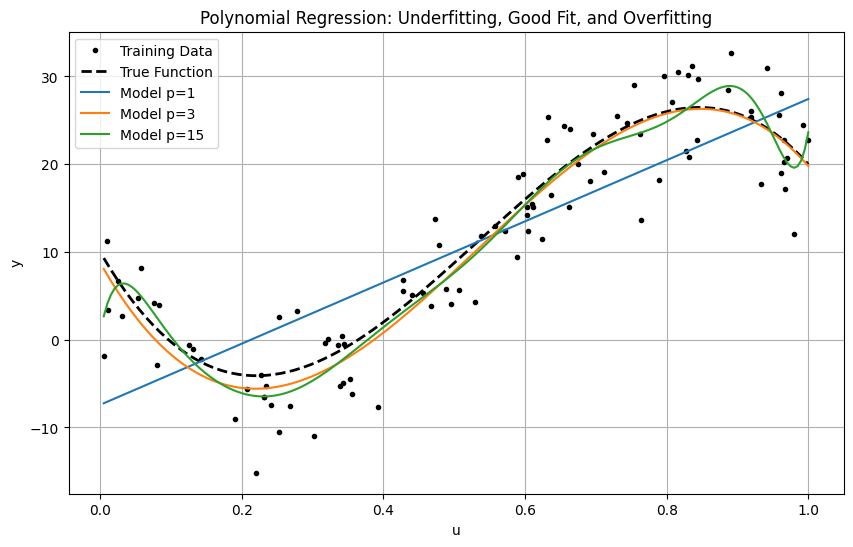

In [11]:
# Parameters to adjust for experiments
beta = np.array([[10, -140, 400, -250]]).T  # degree 3
n = 100
sig = 5

# Generate training data
u, y = generate_data(3, beta, sig, n)

# Train models
X, betahat = {}, {}
ps = [1, 3, 15]
for p in ps:
    X[p] = model_matrix(p, u)
    betahat[p] = train(X[p], y)

# Test on new data
u_test, y_test = generate_data(3, beta, sig, n)


X_test = {}
training_loss = {}
test_loss = {}
for p in ps:
    X_test[p] = model_matrix(p, u_test)
    training_loss[p] = test_coefficients(n, betahat[p], X[p], y)
    test_loss[p] = test_coefficients(n, betahat[p], X_test[p], y_test)


# print the losses to see them
print("Training Loss:", training_loss)
print("Test Loss:", test_loss)

# Plot the points and true line and store in the list "plots"
xx = np.arange(np.min(u), np.max(u) + 5e-3, 5e-3)
yy_true = np.polyval(np.flip(beta), xx)

# plots = [plt.plot(u, y, "k.", markersize=8)[0], plt.plot(xx, yy, "k--", linewidth=3)[0]]

plt.figure(figsize=(10,6))
plt.plot(u, y, "k.", label="Training Data")
plt.plot(xx, yy_true, "k--", linewidth=2, label="True Function")

# add the three curves
for i , p in enumerate(ps):
    yy_pred = np.polyval(np.flip(betahat[p]), xx)
    plt.plot(xx, yy_pred, label=f"Model p={p}")


plt.xlabel("u")
plt.ylabel("y")
plt.title("Polynomial Regression: Underfitting, Good Fit, and Overfitting")
plt.legend()
plt.grid(True)
plt.show()

### Observation

When running the experiment with the corrected code, the plot clearly illustrates the concepts of underfitting, a good fit, and overfitting. The true data is generated from a 3rd-degree polynomial (p=3). 

p = 1 (Underfitting): The model is a straight line and is too simple to capture the curve in the data. Its capacity is too low. This results in high bias, meaning the model is systematically wrong, leading to high error on both training and test sets. 


p = 3 (Good Fit): The model's complexity matches the data's underlying structure. It captures the general trend without being overly influenced by random noise. This model has a good bias-variance balance. 


p = 15 (Overfitting): The model is excessively complex. It has so much flexibility that it fits the random noise in the training data, not just the true signal. This results in high variance. The model performs exceptionally well on the training data it has seen, but it generalizes poorly to new, unseen data, leading to a high test error